In [28]:
import numpy as np
from PIL import Image

import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision
from torch.optim.lr_scheduler import LambdaLR
from torchvision.datasets import CIFAR10
from torchvision import transforms as T
from torch.utils.data import SubsetRandomSampler
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.nn.modules.transformer import Transformer
from torchvision.models import resnet18
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from torch.utils.data import Subset
from torch.utils.data import ConcatDataset
from torch.utils.data import TensorDataset
from torchvision.datasets import ImageFolder
import torchvision.datasets as datasets
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
import random
from tqdm import tqdm

In [5]:
def seed_everything():
    seed = 24789
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [20]:
class SimCLR(nn.Module):
    def __init__(self, base_encoder, feature_size, projection_dim=128, temperature=0.5, image_size=224,  mean=(0.5,), std=(0.229, 0.224, 0.225)):
        super().__init__()
        self.enc = base_encoder
        self.image_size = image_size
        self.mean = mean
        self.std = std
        self.projection_dim = projection_dim
        self.temperature = temperature
        # self.feature_size = self.enc.fc.in_features
        self.augment = T.Compose([
                T.RandomResizedCrop(image_size, scale=(0.2, 1.0)),
                T.RandomHorizontalFlip(),
                T.RandomApply([T.ColorJitter(0.8,0.8,0.8,0.2)], p=0.8),
                T.RandomGrayscale(p=0.2),
                T.RandomApply([T.GaussianBlur(kernel_size= image_size//20*2+1, sigma=(0.1, 2.0))], p=0.5),
                T.Normalize(mean=mean, std=std),
                ])

        self.projector = Projector(feature_size, hidden_dim=feature_size, out_dim=projection_dim)
        self.encoder = nn.Sequential(base_encoder, self.projector)

    def forward(self, x):
        x1, x2 = self.augment(x), self.augment(x)
        z1, z2 = self.encoder(x1), self.encoder(x2)
        loss = nt_xent(z1, z2, self.temperature)
        return loss

class Projector(nn.Module):

    def __init__(self, in_dim, hidden_dim=None, out_dim=128):
        super().__init__()

        if hidden_dim is None:
            self.layer1 = nn.Linear(in_dim, out_dim)
        else:
            self.layer1 = nn.Sequential(
                    nn.Linear(in_dim, hidden_dim),
                    nn.ReLU(inplace=True),
                    nn.Linear(hidden_dim, out_dim),
                )
    def forward(self, x):
        x = self.layer1(x)
        return x


def nt_xent(z1, z2, temperature=0.5):
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)
    N, Z = z1.shape
    device = z1.device
    representations = torch.cat([z1, z2], dim=0)
    similarity_matrix = F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=-1)
    l_pos = torch.diag(similarity_matrix, N)
    r_pos = torch.diag(similarity_matrix, -N)
    positives = torch.cat([l_pos, r_pos]).view(2 * N, 1)
    diag = torch.eye(2*N, dtype=torch.bool, device=device)
    diag[N:,:N] = diag[:N,N:] = diag[:N,:N]
    negatives = similarity_matrix[~diag].view(2*N, -1)
    logits = torch.cat([positives, negatives], dim=1)
    logits /= temperature
    labels = torch.zeros(2*N, device=device, dtype=torch.int64)
    loss = F.cross_entropy(logits, labels, reduction='sum')
    return loss / (2 * N)

In [21]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name):
        self.name = name
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [38]:
batch_size = 256
projection_dim = 128
learning_rate = 5e-4
momentum = 0.95
weight_decay = 1e-5
epochs = 5
temperature = 0.5

In [39]:
assert torch.cuda.is_available()
cudnn.benchmark = True

data_dir = "/content"

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

base_encoder = torchvision.models.resnet18(pretrained = False)
feature_size = base_encoder.fc.in_features
base_encoder.fc = torch.nn.Identity()

kwargs = {
    'image_size': 32,
    'mean': [0.4914, 0.4822, 0.4465],
    'std': [0.2023, 0.1994, 0.2010]
    }

model = SimCLR(base_encoder, feature_size, temperature = 0.5, **kwargs).cuda()
optimizer = optim.AdamW(model.parameters(), lr= learning_rate, weight_decay=weight_decay)

Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


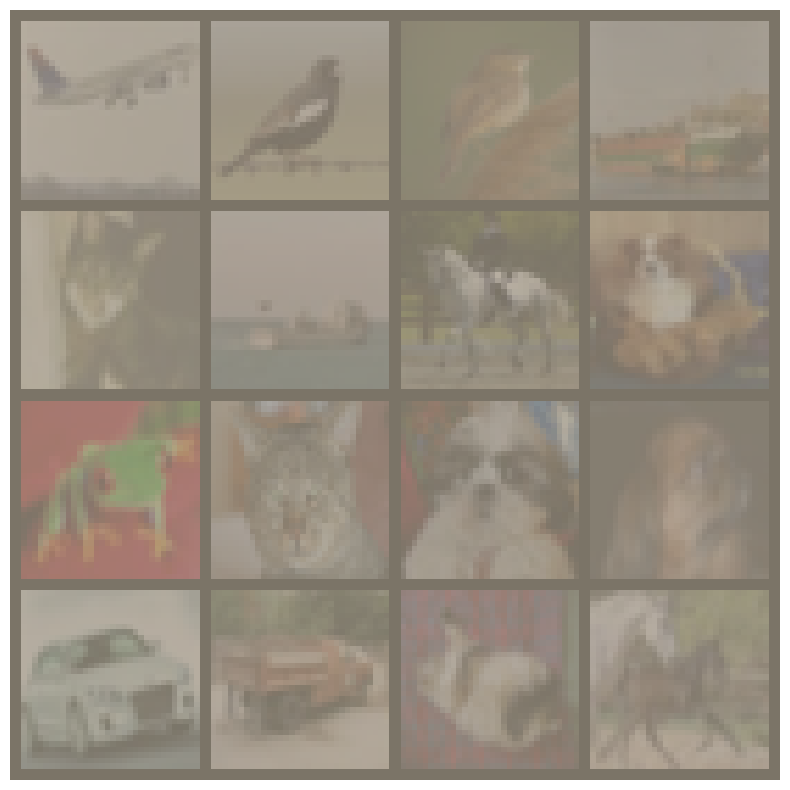

In [40]:
data_iter = iter(train_loader)
images, _ = next(data_iter)
images = images[:16]

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

img_grid = torchvision.utils.make_grid(images, nrow=4)
img_np = img_grid.numpy()
img_np = np.transpose(img_np, (1, 2, 0))  # changeing the shape from (C,H,W) to (H,W,C)
img_np = img_np * std[None, None, :] + mean[None, None, :]  # Correcting broadcasting for normalization
img_np = np.clip(img_np, 0., 1.)  # Cliping the values to be between 0 and 1

plt.figure(figsize=(10, 10))
plt.imshow(img_np)
plt.axis('off')
plt.show()


In [41]:
def accuracy_metric(model, reference_loader, train_loader):
    model.eval()

    # Step 1: Prepare reference feature embeddings
    reference_features = []
    reference_labels = []

    with torch.no_grad():
        for imgs, labels in reference_loader:
            imgs = imgs.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            features = model.enc(imgs)  # get the features from the base encoder
            features = features.view(features.size(0), -1)  # Flatten the features
            reference_features.append(features.cpu())
            reference_labels.append(labels.cpu())

    reference_features = torch.cat(reference_features)
    reference_labels = torch.cat(reference_labels)

    correct = 0
    total = 0

    # Obtaining the feature embeddings for training data and Compute similarity scores
    with torch.no_grad():
        for batch_num, (imgs, labels) in enumerate(train_loader):
            imgs = imgs.cuda(non_blocking=True)
            labels = labels.cuda(non_blocking=True)
            features = model.enc(imgs)  # get the features from the base encoder
            features = features.view(features.size(0), -1)
            reference_features_device = reference_features.to(features.device)
            similarities = torch.mm(features, reference_features_device.t())

            # Assigning the labels based on similarity
            _, pred_labels = torch.max(similarities, dim=1)  # index of the maximum similarity for each image, which are the predicted labels.

            # Converting reference labels to the same device as pred_labels
            reference_labels_device = reference_labels.to(pred_labels.device)

            pred_labels_mapped = torch.index_select(reference_labels_device, 0, pred_labels)

            # Evaluating accuracy
            total += labels.size(0)
            correct += (pred_labels_mapped == labels).sum().item()

    accuracy = correct / total
    return accuracy


In [42]:
# Initialize empty lists to hold the subsets for each class
subsets = []

# Number of examples per class and number of classes
n_examples = 5
n_classes = 10

# Looping over each class
for i in range(n_classes):
    # Get indices of all examples from this class
    indices = [j for j, (img, label) in enumerate(train_dataset) if label == i]

    # Randomly select n_examples from these indices
    random_indices = random.sample(indices, n_examples)

    # Creating subset for this class and add it to the list
    subsets.append(Subset(train_dataset, random_indices))

# Concatenate all subsets to create the final reference set
reference_data = ConcatDataset(subsets)

# reference_data = Subset(train_set, indices=range(50))  # choose first 50 data points as reference
reference_loader = DataLoader(reference_data, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [45]:
def train(args) -> None:
    model.train()
    best_loss = np.inf
    train_losses = []
    train_accs = []

    for epoch in range(1, args['epochs'] + 1):
        loss_meter = AverageMeter("SimCLR_loss")
        train_bar = tqdm(train_loader)
        for x, y in train_bar:
            x = x.cuda(non_blocking=True)
            optimizer.zero_grad()

            loss = model(x)
            loss.backward()
            optimizer.step()

            loss_meter.update(loss.item(), x.size(0))
            train_losses.append(loss_meter.avg)

            train_bar.set_description("Train epoch {}, SimCLR loss: {:.4f}".format(epoch, loss_meter.avg))

        accuracy = accuracy_metric(model, reference_loader, train_loader)
        train_accs.append(accuracy)
        print(f"Epoch: {epoch}, Accuracy: {accuracy*100:.2f}%")

        if loss.item() < best_loss:
            best_loss = loss.item()
            torch.save(model.state_dict(), 'simclr_best_epoch.pt'.format(epoch))

    plt.figure(figsize=(12, 4))
    # Plotting Loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()


    # Plotting Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

  0%|          | 0/196 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Train epoch 1, SimCLR loss: 5.2596: 100%|██████████| 196/196 [00:31<00:00,  6.20it/s]


Epoch: 1, Accuracy: 14.31%


Train epoch 2, SimCLR loss: 6.2398: 100%|██████████| 196/196 [00:32<00:00,  6.06it/s]


Epoch: 2, Accuracy: 10.00%


Train epoch 3, SimCLR loss: 6.2333: 100%|██████████| 196/196 [00:32<00:00,  6.09it/s]


Epoch: 3, Accuracy: 10.00%


Train epoch 4, SimCLR loss: 6.2345: 100%|██████████| 196/196 [00:32<00:00,  6.07it/s]


Epoch: 4, Accuracy: 10.00%


Train epoch 5, SimCLR loss: 6.2345: 100%|██████████| 196/196 [00:32<00:00,  6.04it/s]


Epoch: 5, Accuracy: 10.00%


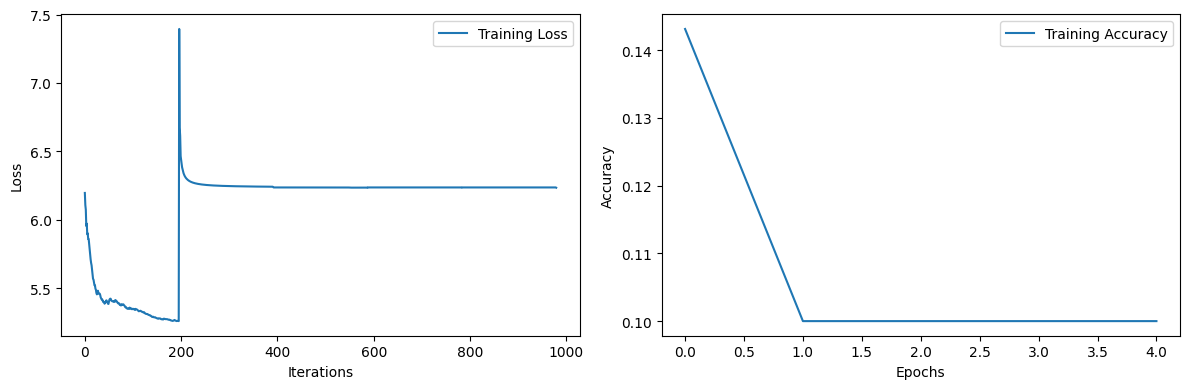

In [46]:
args = {
    'epochs':  epochs,
    'batch_size': batch_size,
}

train(args)

In [47]:
def get_classwise_indices(dataset, num_samples):
    # Dictionary to hold class-wise indices
    class_indices = {i: [] for i in range(10)}

    # Iterating over the entire dataset to collect class-wise indices
    for i in range(len(dataset)):
        class_label = dataset[i][1]
        class_indices[class_label].append(i)

    # Selecting num_samples from each class
    for class_label in class_indices:
        if len(class_indices[class_label]) > num_samples:
            class_indices[class_label] = random.sample(class_indices[class_label], num_samples)

    # Flatten the dictionary values to get a list of indices
    indices = [idx for class_list in class_indices.values() for idx in class_list]

    return indices

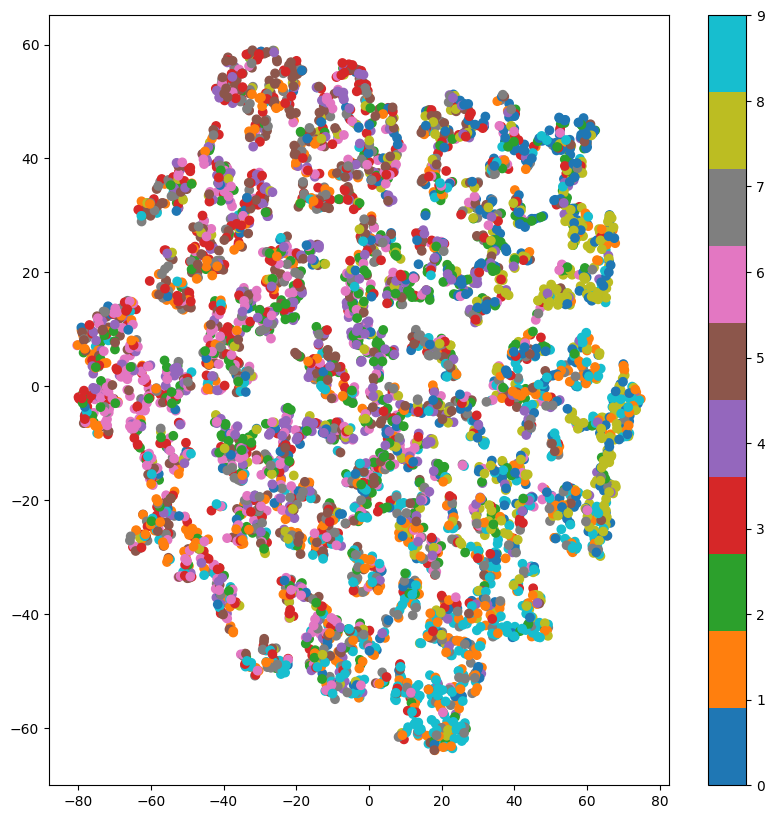

In [48]:
def visualize_tsne(features, labels):
    tsne = TSNE(n_components=2, random_state=123).fit_transform(features)
    plt.figure(figsize=(10, 10))
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, cmap='tab10')
    plt.colorbar()
    plt.show()

# Loading the trained model
model.load_state_dict(torch.load('simclr_best_epoch.pt'))
model.eval()

num_samples = 500
indices = get_classwise_indices(train_dataset, num_samples)
subset_loader = DataLoader(train_dataset, batch_size=500, sampler=torch.utils.data.SubsetRandomSampler(indices))

# Collecting features and labels from all batches
features_all = []
labels_all = []

with torch.no_grad():
    for x, y in subset_loader:
        x = x.cuda(non_blocking=True)
        features = model.enc(x)
        features = features.view(features.size(0), -1)

        features_all.append(features.cpu().numpy())
        labels_all.append(y.numpy())

# Concatenate all features and labels
features_all = np.concatenate(features_all, axis=0)
labels_all = np.concatenate(labels_all, axis=0)

# Calling the visualization function once, with all features and labels
visualize_tsne(features_all, labels_all)